https://www.kaggle.com/ronitf/heart-disease-uci

https://pennylane.ai/qml/demos/quantum_neural_net.html#quantum-neural-net

# QNN 

In [1]:
# import libraries
from Qsun.Qcircuit import *
from Qsun.Qgates import *
from Qsun.Qmeas import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score

# one layer with full entanglement
def layer(circuit, params):
    circuit_layer = circuit
    n_qubit = len(params)
    for i in range(n_qubit):
        RX(circuit_layer, i, params[i][0])
        RY(circuit_layer, i, params[i][1])
    for i in range(n_qubit-1):
        CNOT(circuit_layer, i, i+1)
    CNOT(circuit_layer, n_qubit-1, 0)
    return circuit_layer

# encoding the features
def initial_state(sample):
    circuit_initial = Qubit(len(sample))
    ampli_vec = np.array([np.sqrt(sample[0]), np.sqrt(1-sample[0])])
    for i in range(1, len(sample)):
        ampli_vec = np.kron(ampli_vec, np.array([np.sqrt(sample[i]), np.sqrt(1-sample[i])]))
    circuit_initial.amplitude = ampli_vec
    return circuit_initial

# QNN circuit
def qnn(circuit, params):
    n_layer = len(params)
    circuit_qnn = circuit
    for i in range(n_layer):
        circuit_qnn = layer(circuit_qnn, params[i])
    return circuit_qnn

# QNN model
def qnn_model(sample, params):
    circuit_model = initial_state(sample)
    circuit_model = qnn(circuit_model, params)
    return circuit_model

# activation function
def sigmoid(x):
    return 1 / (1 + math.exp(-10*x))

# make a prediction
def predict(circuit):
    prob_0 = measure_one(circuit, 0)
    prob_1 = measure_one(circuit, 1)
    expval_0 = prob_0[1]
    expval_1 = prob_1[1]
    pred = sigmoid(expval_0-expval_1)
    return [pred, 1-pred]

# make a prediction for ex
def predict_ex(circuit):
    prob_0 = measure_one(circuit, 0)
    prob_1 = measure_one(circuit, 1)
    expval_0 = prob_0[1]
    expval_1 = prob_1[1]
    return [expval_0, expval_1]

# loss function    
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (1 - p[l]) ** 2
    loss = loss / len(labels)
    return loss

# loss function of QNN
def cost(params, features, labels):
    preds = [predict(qnn_model(x, params)) for x in features]
    return square_loss(labels, preds)

# gradient descent with QDP
def grad(X_true, y_true, params, shift, eta, drop_rate):
    diff = np.zeros(params.shape)
    for i in range(len(params)):
        for j in range(len(params[i])):
            for k in range(len(params[i][j])):
                dropout = np.random.choice([0, 1], 1, p = [1 - drop_rate, drop_rate])[0]
                if dropout == 0:
                    params_1 = params.copy()
                    params_2 = params.copy()
                    params_1[i][j][k] += shift
                    params_2[i][j][k] -= shift
                    for x, y in zip(X_true, y_true):
                        circuit = qnn_model(x, params)
                        circuit_1 = qnn_model(x, params_1)
                        circuit_2 = qnn_model(x, params_2)
                        ex_plus = predict_ex(circuit_1)
                        ex_subs = predict_ex(circuit_2)
                        pred = predict(circuit)
                        diff_loss = ((-1)**y)*(-2)*(1-pred[y])*pred[y]*(1-pred[y])
                        diff_ex = 10*((ex_plus[0] - ex_subs[0]) - (ex_plus[1] - ex_subs[1]))/(2*np.sin(shift))
                        diff[i][j][k] += diff_loss*diff_ex
                                                
    diff /= len(y_true)                
    params -= eta*diff
                
    return params

# adagrad: https://d2l.ai/chapter_optimization/adagrad.html                        

def adagrad(X_true, y_true, params, s, shift, eta, drop_rate, eps):
    diff = np.zeros(params.shape)
    for i in range(len(params)):
        for j in range(len(params[i])):
            for k in range(len(params[i][j])):
                dropout = np.random.choice([0, 1], 1, p = [1 - drop_rate, drop_rate])[0]
                if dropout == 0:
                    params_1 = params.copy()
                    params_2 = params.copy()
                    params_1[i][j][k] += shift
                    params_2[i][j][k] -= shift
                    for x, y in zip(X_true, y_true):
                        circuit = qnn_model(x, params)
                        circuit_1 = qnn_model(x, params_1)
                        circuit_2 = qnn_model(x, params_2)
                        ex_plus = predict_ex(circuit_1)
                        ex_subs = predict_ex(circuit_2)
                        pred = predict(circuit)
                        diff_loss = ((-1)**y)*(-2)*(1-pred[y])*pred[y]*(1-pred[y])
                        diff_ex = 10*((ex_plus[0] - ex_subs[0]) - (ex_plus[1] - ex_subs[1]))/(2*np.sin(shift))
                        diff[i][j][k] += diff_loss*diff_ex
                                                
    diff /= len(y_true)
    s += diff**2
    params -= eta*diff/np.sqrt(s+eps)
                
    return params, s

# https://d2l.ai/chapter_optimization/adam.html?highlight=adam

def adam(X_true, y_true, params, v, s, shift, eta, drop_rate, beta1, beta2, eps, iter_num):
    diff = np.zeros(params.shape)
    for i in range(len(params)):
        for j in range(len(params[i])):
            for k in range(len(params[i][j])):
                dropout = np.random.choice([0, 1], 1, p = [1 - drop_rate, drop_rate])[0]
                if dropout == 0:
                    params_1 = params.copy()
                    params_2 = params.copy()
                    params_1[i][j][k] += shift
                    params_2[i][j][k] -= shift
                    for x, y in zip(X_true, y_true):
                        circuit = qnn_model(x, params)
                        circuit_1 = qnn_model(x, params_1)
                        circuit_2 = qnn_model(x, params_2)
                        ex_plus = predict_ex(circuit_1)
                        ex_subs = predict_ex(circuit_2)
                        pred = predict(circuit)
                        diff_loss = ((-1)**y)*(-2)*(1-pred[y])*pred[y]*(1-pred[y])
                        diff_ex = 10*((ex_plus[0] - ex_subs[0]) - (ex_plus[1] - ex_subs[1]))/(2*np.sin(shift))
                        diff[i][j][k] += diff_loss*diff_ex
                                                
    diff /= len(y_true)
    v = beta1 * v + (1 - beta1) * diff
    s = beta2 * s + (1 - beta2) * (diff**2)
    v_bias_corr = v / (1 - beta1 ** (iter_num+1))
    s_bias_corr = s / (1 - beta2 ** (iter_num+1))
    params -= eta * v_bias_corr / (np.sqrt(s_bias_corr) + eps)
    
    return params, v, s

In [2]:
def qnn_training(X_true, y_true, params, max_ieration, shift=np.pi/20, eta=0.1, drop_rate=0.1, choice='grad'):
    if choice == 'grad':
        for k in range(max_ieration):
            params = grad(X_train, y_train, params, shift, eta, drop_rate)
    elif choice == 'adagrad':
        s = np.zeros(params.shape)
        for k in range(max_ieration):
            params, s = adagrad(X_train, y_train, params, s, shift, eta, drop_rate, 1e-6)
    elif choice == 'adam':
        v = np.zeros(params.shape)
        s = np.zeros(params.shape)
        for k in range(max_ieration):
            params, v, s = adam(X_train, y_train, params, v, s, shift, eta, drop_rate, 0.9, 0.999, 1e-6, k)
    return params

In [3]:
# source: https://www.kaggle.com/rakeshrau/social-network-ads
dataset = pd.read_csv('Social_Network_Ads.csv')
X = dataset.iloc[:, 2:-1].values
y = dataset.iloc[:, -1].values

# splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# scaling feature
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# create parameters  
n_layer = 3
params = np.zeros((n_layer, len(X_train[0]), 2,))

# #source: https://www.kaggle.com/ronitf/heart-disease-uci
# dataset = pd.read_csv('heart.csv')
# dataset = dataset[['age', 'chol', 'target']]
# X = dataset.iloc[:, 0:-1].values
# y = dataset.iloc[:, -1].values

# # splitting dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
# X_test = np.delete(X_test, 10, 0)
# y_test = np.delete(y_test, 10, 0)

# # scaling feature
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [4]:
# from sklearn import preprocessing
# from sklearn.decomposition import PCA

# #source: https://www.kaggle.com/rakeshrau/social-network-ads
# dataset = pd.read_csv('Social_Network_Ads.csv')

# # encoding gender
# le = preprocessing.LabelEncoder()
# dataset['Gender'] = le.fit_transform(dataset['Gender'])

# X = dataset.iloc[:, 2:-1].values
# y = dataset.iloc[:, -1].values

# # dimensionality reduction
# pca = PCA(n_components=2, svd_solver='full')
# X = pca.fit_transform(X)

# # splitting dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# # scaling feature
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_train = np.round(X_train, 10)
# X_test = scaler.transform(X_test)
# X_test = np.round(X_train, 10)

# # create parameters  
# n_layer = 3
# params = np.zeros((n_layer, len(X_train[0]), 2,))

In [15]:
start = time.time()
params = np.zeros((n_layer, len(X_train[0]), 2,)) 
params = qnn_training(X_train, y_train, params, 1, np.pi/20, eta=0.1, drop_rate=0, choice = 'adam')
print(time.time() - start)

3.9513821601867676


In [11]:
label_train = y_train
pred_train = [predict(qnn_model(x, params)) for x in X_train]
pred_train = np.argmax(pred_train, axis=1)

accuracy_score(label_train, pred_train)

0.85625

# Multi-Layer

## Classical Neural Network

In [4]:
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier

In [5]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
# from tensorflow.keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
# import tensorflow as tf
# from tensorflow import keras

In [6]:
df = pd.read_csv('Social_Network_Ads.csv')
X = df.iloc[:,2:-1]
y = df.iloc[:,-1]

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=.2, random_state=2, stratify=y)

# folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)
# param_grid = [
#         {
#             'activation' : ['identity', 'logistic', 'tanh', 'relu'],
#             'solver' : ['lbfgs', 'sgd', 'adam'],            
#         }
#        ]
# clf = GridSearchCV(MLPClassifier(hidden_layer_sizes=(100, 100, 100)), param_grid, cv=folds,
#                            scoring='accuracy',n_jobs=-1,verbose = 1,
# )
# clf.fit(X_train, y_train)
# print(f' Training Accuracy {clf.score(X_train,y_train)}')
# f'Test Accuracy {clf.score(X_test,y_test)}'

In [7]:
costs_train_nn = []
costs_test_nn = []
accuracy_train_nn = []
accuracy_test_nn = []

In [8]:
for l in range(1, 6):    
    costs_train = []
    layers = (100, )*l
    clf = MLPClassifier(hidden_layer_sizes=layers, activation='relu', solver = 'adam', max_iter=100, tol=-1).fit(X_train, y_train)
    costs_train_nn.append(clf.loss_curve_)

In [9]:
SIZE = 34*1.3
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title

In [28]:
# plt.figure(figsize=(20,13.33))
# for l in range(1, 6):
#     plt.plot(range(1, len(costs_train_nn[l-1])+1), costs_train_nn[l-1], linewidth=4, label=str(l)+'-Layer')
# plt.tick_params(axis="x", which = 'major', direction="in", length=16, width=4)
# plt.tick_params(axis="y", which = 'major', direction="in", length=16, width=4)
# plt.tick_params(axis="y", which = 'minor', direction="in", length=8, width=4)
# # plt.yscale('log')
# plt.xlabel('iteration')
# plt.legend(loc='upper right')
# plt.ylabel('Loss')
# plt.savefig('layer_train_nn_cost.png')
# plt.savefig('layer_train_nn_cost.eps', format='eps')

## QNN

In [11]:
#source: https://www.kaggle.com/rakeshrau/social-network-ads
dataset = pd.read_csv('Social_Network_Ads.csv')
X = dataset.iloc[:, 2:-1].values
y = dataset.iloc[:, -1].values

# splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# scaling feature
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
costs_train_qnn = []
costs_test_qnn = []
accuracy_train_qnn = []
accuracy_test_qnn = []

label_train = y_train
label_test = y_test

# training model
for l in range(1, 6):
    start = time.time()

    params = np.zeros((l, len(X_train[0]), 2,))
    v = np.zeros(params.shape)
    s = np.zeros(params.shape)
    
    costs_train = []
    costs_test = []
    accuracy_train = []
    accuracy_test = []

    for i in range(100):
        params, v, s = adam(X_train, y_train, params, v, s, 
                            shift=np.pi/20, eta=0.1, drop_rate=0.0, beta1=0.9, beta2=0.999, eps=1e-6, iter_num=i)

        pred_train = [predict(qnn_model(x, params)) for x in X_train]
        pred_train = np.argmax(pred_train, axis=1)

        pred_test = [predict(qnn_model(x, params)) for x in X_test]
        pred_test = np.argmax(pred_test, axis=1)

        costs_train.append(cost(params, X_train, y_train))
        costs_test.append(cost(params, X_test, y_test))
        accuracy_train.append(accuracy_score(label_train, pred_train))
        accuracy_test.append(accuracy_score(label_test, pred_test))
    
    costs_train_qnn.append(costs_train)
    costs_test_qnn.append(costs_test)
    accuracy_train_qnn.append(accuracy_train)
    accuracy_test_qnn.append(accuracy_test)
    
    #     if costs_train[-1] >= costs_train[-2]:
    #         break
    print(time.time()-start)

80.52104330062866
224.51061129570007
449.7974362373352
744.2228474617004
1094.0884764194489


In [124]:
SIZE = 34*2
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


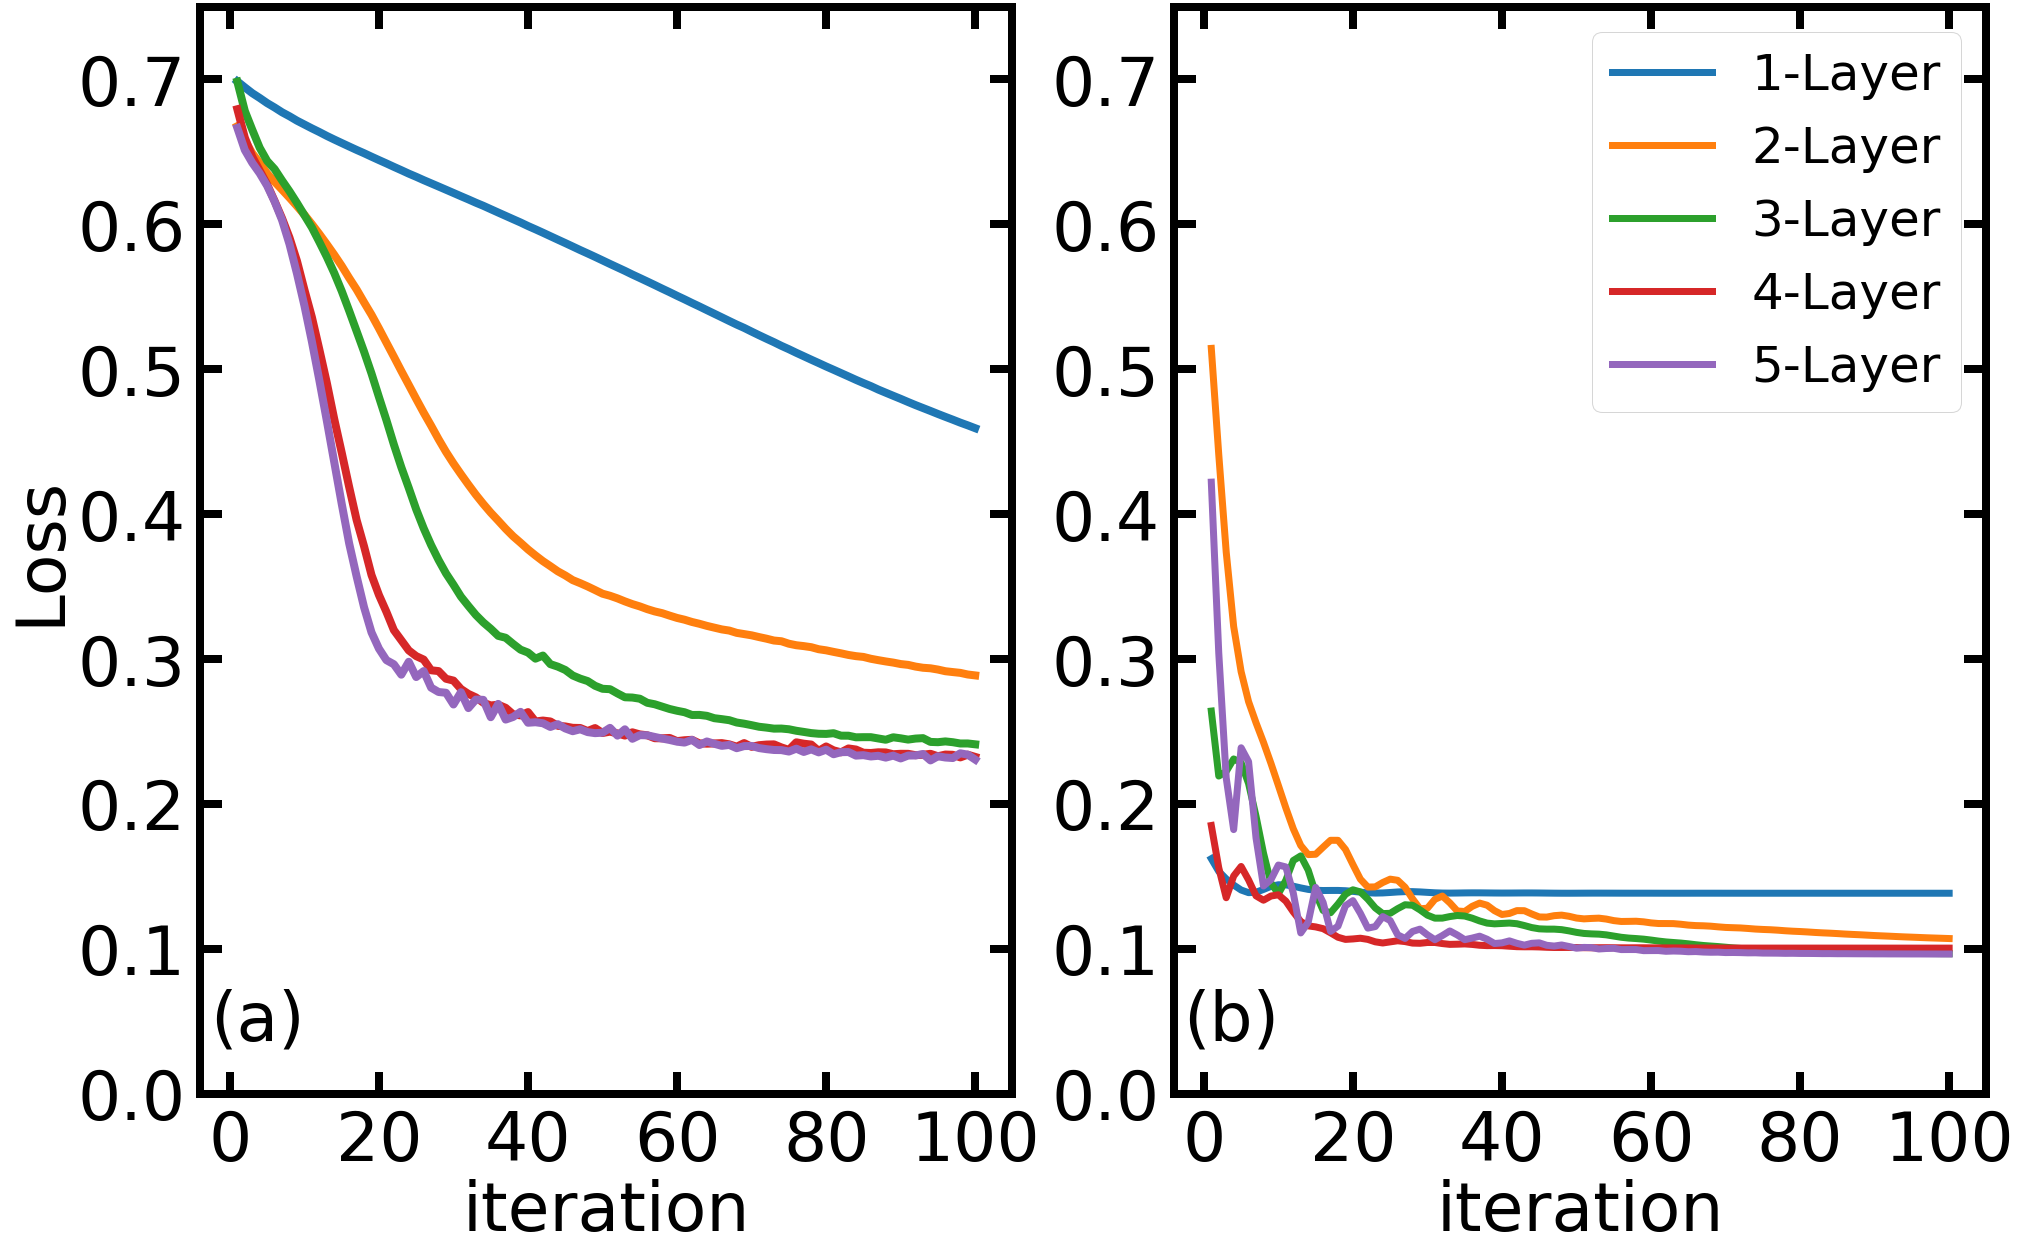

In [138]:
# fig, axes = plt.subplots(1, 2, figsize=(40,13.33))
# fig.suptitle('Loss function')
fig, axes = plt.subplots(1, 2, figsize=(40*0.8, 20), linewidth=8)

# Bulbasaur
for l in range(1, 6):
    axes[0].plot(range(1, len(costs_train_nn[l-1])+1), costs_train_nn[l-1], linewidth=8, label=str(l)+'-Layer')
axes[0].tick_params(axis="x", which = 'major', direction="in", length=22, width=8, pad=15)
axes[0].tick_params(axis="y", which = 'major', direction="in", length=22, width=8, pad=15)
axes[0].tick_params(axis="y", which = 'minor', direction="in", length=8, width=8, pad=15)
axes[0].tick_params(top=True, right=True)
axes[0].set_xlabel('iteration')
axes[0].set_ylabel('Loss')
axes[0].text(.07,0.05,'(a)',
        horizontalalignment='center',
        transform=axes[0].transAxes)
for axis in ['top','bottom','left','right']:
    axes[0].spines[axis].set_linewidth(8)
    axes[0].spines[axis].set_zorder(0)
axes[0].set_ylim(0, 0.75)
axes[0].set_xticks(np.arange(0, 120, 20))
axes[0].set_yticks(np.arange(0, .8, .1))

# Charmander
for l in range(1, 6):
    axes[1].plot(range(1, len(costs_train_qnn[l-1])+1), costs_train_qnn[l-1], linewidth=7, label=str(l)+'-Layer')
axes[1].tick_params(axis="x", which = 'major', direction="in", length=22, width=8, pad=15)
axes[1].tick_params(axis="y", which = 'major', direction="in", length=22, width=8, pad=15)
axes[1].tick_params(axis="y", which = 'minor', direction="in", length=8, width=8, pad=15)
axes[1].tick_params(top=True, right=True)
axes[1].set_xlabel('iteration')
# axes[1].set_ylabel('Loss')
axes[1].text(.07,0.05,'(b)',
        horizontalalignment='center',
        transform=axes[1].transAxes)
axes[1].legend(loc='upper right', fontsize=50)
for axis in ['top','bottom','left','right']:
    axes[1].spines[axis].set_linewidth(8)
    axes[1].spines[axis].set_zorder(0)
axes[1].set_ylim(0, 0.75)
axes[1].set_xticks(np.arange(0, 120, 20))
axes[1].set_yticks(np.arange(0, .8, .1))

plt.savefig('layer_train.png')
plt.savefig('layer_train.eps', format='eps')

In [26]:
# plt.figure(figsize=(20,13.33))
# for l in range(1, 6):
#     plt.plot(range(1, len(costs_train_qnn[l-1])+1), costs_train_qnn[l-1], linewidth=4, label=str(l)+'-Layer')
# plt.tick_params(axis="x", which = 'major', direction="in", length=16, width=4)
# plt.tick_params(axis="y", which = 'major', direction="in", length=16, width=4)
# plt.tick_params(axis="y", which = 'minor', direction="in", length=8, width=4)
# # plt.yscale('log')
# plt.xlabel('iteration')
# plt.legend(loc='upper right')
# plt.ylabel('Loss')
# plt.savefig('layer_train_qnn_cost.png')
# plt.savefig('layer_train_qnn_cost.eps', format='eps')

In [27]:
# plt.figure(figsize=(20,13.33))
# for layer in range(1, 6):
#     plt.plot(range(1, len(accuracy_train_qnn[layer-1])+1), accuracy_train_qnn[layer-1], linewidth=4, label=str(layer)+'-Layer')
# plt.tick_params(axis="x", which = 'major', direction="in", length=16, width=4)
# plt.tick_params(axis="y", which = 'major', direction="in", length=16, width=4)
# plt.tick_params(axis="y", which = 'minor', direction="in", length=8, width=4)
# # plt.yscale('log')
# plt.xlabel('iteration')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.savefig('layer_train_qnn_accuracy.png')
# plt.savefig('layer_train_qnn_accuracy.eps', format='eps')

# Grid Search

In [7]:
n_layer = 3
params = np.zeros((n_layer, len(X_train[0]), 2,))

step = 10

shifts = np.arange(0.0001, np.pi, np.pi/10)
# etas = np.array([0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 25, 50])
etas = np.array([0.1, 5, 10, 15, 20, 25, 30, 35, 40, 45])


shifts, etas = np.meshgrid(shifts, etas)

In [8]:
np.arange(0.0001, np.pi, np.pi/10)

array([1.00000000e-04, 3.14259265e-01, 6.28418531e-01, 9.42577796e-01,
       1.25673706e+00, 1.57089633e+00, 1.88505559e+00, 2.19921486e+00,
       2.51337412e+00, 2.82753339e+00])

In [9]:
np.array([0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 25, 50])


array([1.0e-03, 1.0e-02, 1.0e-01, 5.0e-01, 1.0e+00, 2.0e+00, 5.0e+00,
       1.0e+01, 2.5e+01, 5.0e+01])

In [8]:
# training model
costs_train = np.zeros((step, step))
costs_test = np.zeros((step, step))

for i in range(5):
    for j in range(5):
#         start = time.time()
        params = np.zeros((n_layer, len(X_train[0]), 2,))
        params = qnn_training(X_train, y_train, params, 10, shifts[i][j], etas[i][j], drop_rate=0, choice = 'adam')
#         print(time.time()-start)
        costs_train[i][j] = cost(params, X_train, y_train)
        costs_test[i][j] = cost(params, X_test, y_test)

In [9]:
costs_train

array([[0.3813174 , 0.3813174 , 0.3813174 , 0.3813174 , 0.3813174 ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.26508908, 0.26508908, 0.26508908, 0.26508908, 0.26508908,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.13791905, 0.13791905, 0.13791905, 0.13791905, 0.13791905,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.13427099, 0.13427098, 0.13427098, 0.13427098, 0.13427098,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.15434102, 0.15434119, 0.15434119, 0.15434119, 0.15434119,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [10]:
costs_test

array([[0.31482118, 0.31482118, 0.31482118, 0.31482118, 0.31482118,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.20889429, 0.20889429, 0.20889429, 0.20889429, 0.20889429,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.06375428, 0.06375428, 0.06375428, 0.06375428, 0.06375428,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.08079674, 0.08079672, 0.08079672, 0.08079672, 0.08079672,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.09946434, 0.09946461, 0.09946461, 0.09946461, 0.09946461,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [11]:
for i in range(5):
    for j in range(5, 10):
#         start = time.time()
        params = np.zeros((n_layer, len(X_train[0]), 2,))
        params = qnn_training(X_train, y_train, params, 10, shifts[i][j], etas[i][j], drop_rate=0, choice = 'adam')
#         print(time.time()-start)
        costs_train[i][j] = cost(params, X_train, y_train)
        costs_test[i][j] = cost(params, X_test, y_test)

In [12]:
costs_train

array([[0.3813174 , 0.3813174 , 0.3813174 , 0.3813174 , 0.3813174 ,
        0.3813174 , 0.3813174 , 0.3813174 , 0.3813174 , 0.3813174 ],
       [0.26508908, 0.26508908, 0.26508908, 0.26508908, 0.26508908,
        0.26508908, 0.26508908, 0.26508908, 0.26508908, 0.26508908],
       [0.13791905, 0.13791905, 0.13791905, 0.13791905, 0.13791905,
        0.13791905, 0.13791905, 0.13791905, 0.13791905, 0.13791905],
       [0.13427099, 0.13427098, 0.13427098, 0.13427098, 0.13427098,
        0.13427098, 0.13427098, 0.13427098, 0.13427098, 0.13427098],
       [0.15434102, 0.15434119, 0.15434119, 0.15434119, 0.15434119,
        0.15434119, 0.15434119, 0.15434119, 0.15434119, 0.15434119],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [13]:
costs_test

array([[0.31482118, 0.31482118, 0.31482118, 0.31482118, 0.31482118,
        0.31482118, 0.31482118, 0.31482118, 0.31482118, 0.31482118],
       [0.20889429, 0.20889429, 0.20889429, 0.20889429, 0.20889429,
        0.20889429, 0.20889429, 0.20889429, 0.20889429, 0.20889429],
       [0.06375428, 0.06375428, 0.06375428, 0.06375428, 0.06375428,
        0.06375428, 0.06375428, 0.06375428, 0.06375428, 0.06375428],
       [0.08079674, 0.08079672, 0.08079672, 0.08079672, 0.08079672,
        0.08079672, 0.08079672, 0.08079672, 0.08079672, 0.08079672],
       [0.09946434, 0.09946461, 0.09946461, 0.09946461, 0.09946461,
        0.09946461, 0.09946461, 0.09946461, 0.09946461, 0.09946461],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [14]:
for i in range(5, 10):
    for j in range(5):
#         start = time.time()
        params = np.zeros((n_layer, len(X_train[0]), 2,))
        params = qnn_training(X_train, y_train, params, 10, shifts[i][j], etas[i][j], drop_rate=0, choice = 'adam')
#         print(time.time()-start)
        costs_train[i][j] = cost(params, X_train, y_train)
        costs_test[i][j] = cost(params, X_test, y_test)

In [15]:
costs_train

array([[0.3813174 , 0.3813174 , 0.3813174 , 0.3813174 , 0.3813174 ,
        0.3813174 , 0.3813174 , 0.3813174 , 0.3813174 , 0.3813174 ],
       [0.26508908, 0.26508908, 0.26508908, 0.26508908, 0.26508908,
        0.26508908, 0.26508908, 0.26508908, 0.26508908, 0.26508908],
       [0.13791905, 0.13791905, 0.13791905, 0.13791905, 0.13791905,
        0.13791905, 0.13791905, 0.13791905, 0.13791905, 0.13791905],
       [0.13427099, 0.13427098, 0.13427098, 0.13427098, 0.13427098,
        0.13427098, 0.13427098, 0.13427098, 0.13427098, 0.13427098],
       [0.15434102, 0.15434119, 0.15434119, 0.15434119, 0.15434119,
        0.15434119, 0.15434119, 0.15434119, 0.15434119, 0.15434119],
       [0.32570126, 0.32569919, 0.32569919, 0.32569919, 0.32569919,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.59086286, 0.5910232 , 0.59102322, 0.59102314, 0.5910231 ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.21566036, 0.20003231, 0.2000337

In [16]:
costs_test

array([[0.31482118, 0.31482118, 0.31482118, 0.31482118, 0.31482118,
        0.31482118, 0.31482118, 0.31482118, 0.31482118, 0.31482118],
       [0.20889429, 0.20889429, 0.20889429, 0.20889429, 0.20889429,
        0.20889429, 0.20889429, 0.20889429, 0.20889429, 0.20889429],
       [0.06375428, 0.06375428, 0.06375428, 0.06375428, 0.06375428,
        0.06375428, 0.06375428, 0.06375428, 0.06375428, 0.06375428],
       [0.08079674, 0.08079672, 0.08079672, 0.08079672, 0.08079672,
        0.08079672, 0.08079672, 0.08079672, 0.08079672, 0.08079672],
       [0.09946434, 0.09946461, 0.09946461, 0.09946461, 0.09946461,
        0.09946461, 0.09946461, 0.09946461, 0.09946461, 0.09946461],
       [0.25850945, 0.25850857, 0.25850857, 0.25850857, 0.25850857,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.5815529 , 0.58183437, 0.58183454, 0.58183427, 0.58183413,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.14440762, 0.12627506, 0.1262765

In [17]:
for i in range(5, 10):
    for j in range(5, 10):
#         start = time.time()
        params = np.zeros((n_layer, len(X_train[0]), 2,))
        params = qnn_training(X_train, y_train, params, 10, shifts[i][j], etas[i][j], drop_rate=0, choice = 'adam')
#         print(time.time()-start)
        costs_train[i][j] = cost(params, X_train, y_train)
        costs_test[i][j] = cost(params, X_test, y_test)

In [18]:
costs_train

array([[0.3813174 , 0.3813174 , 0.3813174 , 0.3813174 , 0.3813174 ,
        0.3813174 , 0.3813174 , 0.3813174 , 0.3813174 , 0.3813174 ],
       [0.26508908, 0.26508908, 0.26508908, 0.26508908, 0.26508908,
        0.26508908, 0.26508908, 0.26508908, 0.26508908, 0.26508908],
       [0.13791905, 0.13791905, 0.13791905, 0.13791905, 0.13791905,
        0.13791905, 0.13791905, 0.13791905, 0.13791905, 0.13791905],
       [0.13427099, 0.13427098, 0.13427098, 0.13427098, 0.13427098,
        0.13427098, 0.13427098, 0.13427098, 0.13427098, 0.13427098],
       [0.15434102, 0.15434119, 0.15434119, 0.15434119, 0.15434119,
        0.15434119, 0.15434119, 0.15434119, 0.15434119, 0.15434119],
       [0.32570126, 0.32569919, 0.32569919, 0.32569919, 0.32569919,
        0.32569919, 0.32569919, 0.32569919, 0.32569919, 0.32569919],
       [0.59086286, 0.5910232 , 0.59102322, 0.59102314, 0.5910231 ,
        0.59102311, 0.59102315, 0.59102305, 0.59102318, 0.5910231 ],
       [0.21566036, 0.20003231, 0.2000337

In [19]:
costs_test

array([[0.31482118, 0.31482118, 0.31482118, 0.31482118, 0.31482118,
        0.31482118, 0.31482118, 0.31482118, 0.31482118, 0.31482118],
       [0.20889429, 0.20889429, 0.20889429, 0.20889429, 0.20889429,
        0.20889429, 0.20889429, 0.20889429, 0.20889429, 0.20889429],
       [0.06375428, 0.06375428, 0.06375428, 0.06375428, 0.06375428,
        0.06375428, 0.06375428, 0.06375428, 0.06375428, 0.06375428],
       [0.08079674, 0.08079672, 0.08079672, 0.08079672, 0.08079672,
        0.08079672, 0.08079672, 0.08079672, 0.08079672, 0.08079672],
       [0.09946434, 0.09946461, 0.09946461, 0.09946461, 0.09946461,
        0.09946461, 0.09946461, 0.09946461, 0.09946461, 0.09946461],
       [0.25850945, 0.25850857, 0.25850857, 0.25850857, 0.25850857,
        0.25850857, 0.25850857, 0.25850857, 0.25850857, 0.25850857],
       [0.5815529 , 0.58183437, 0.58183454, 0.58183427, 0.58183413,
        0.58183418, 0.58183433, 0.58183403, 0.58183442, 0.58183411],
       [0.14440762, 0.12627506, 0.1262765

In [14]:
SIZE = 20*1.3
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title

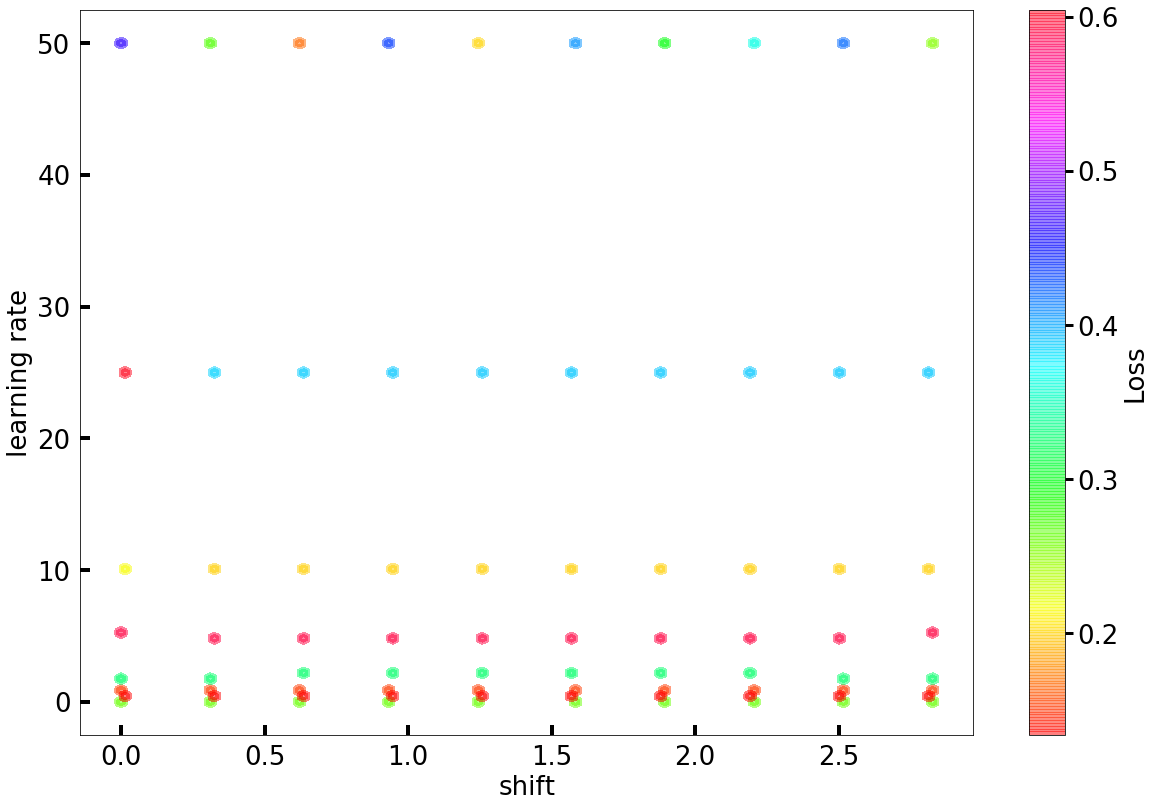

In [60]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,13.33))
ax = plt.axes()
surf = ax.hexbin(shifts.flatten(), etas.flatten(), C=costs_train.flatten(), 
           cmap=plt.get_cmap('hsv'), linewidth=4, antialiased=False, alpha = 0.5)

ax.set_xlabel('shift')
ax.set_ylabel('learning rate')
ax.tick_params(which = 'both', direction="in", length=10, width=4, pad = 10, grid_alpha=0.5)

plt.rcParams['xtick.minor.width'] = 5
bar = fig.colorbar(surf, label='Loss')
bar.ax.tick_params(length = 8, width = 3)

# plt.savefig('grid_search_train_adam.png')
# plt.savefig('grid_search_train_adam.pdf')

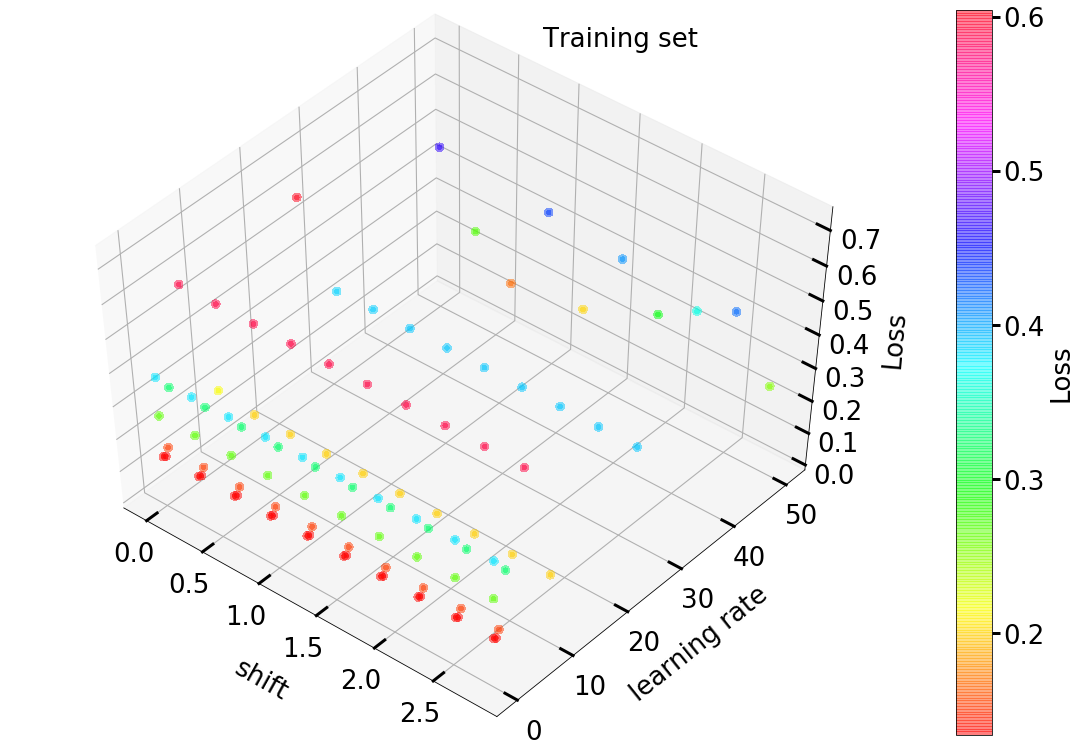

In [39]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,13.33))
ax = plt.axes(projection='3d')
surf = ax.scatter(shifts.flatten(), etas.flatten(), costs_train.flatten(), c=costs_train.flatten(), 
                  cmap=plt.get_cmap('hsv'), linewidth=4, antialiased=False, alpha = 0.5)
ax.set_xlabel('shift', labelpad=40, rotation=-10)
ax.set_ylabel('learning rate', labelpad=30, rotation=40)
ax.set_zlabel('Loss', labelpad=25, rotation=85)
ax.tick_params(which = 'both', direction="in", length=6, width=4, pad = 10, grid_alpha=0.5)
ax.set_zlim3d(0, 0.75)
plt.rcParams['xtick.minor.width'] = 5

ax.xaxis._axinfo['tick']['inward_factor'] = 0
ax.xaxis._axinfo['tick']['outward_factor'] = 0.4
ax.xaxis._axinfo['tick']['linewidth'] = 3
ax.xaxis._axinfo['grid']['linewidth'] = 1.1

ax.yaxis._axinfo['tick']['inward_factor'] = 0
ax.yaxis._axinfo['tick']['outward_factor'] = 0.4
ax.yaxis._axinfo['tick']['linewidth'] = 3
ax.yaxis._axinfo['grid']['linewidth'] = 1.1

ax.zaxis._axinfo['tick']['inward_factor'] = 0
ax.zaxis._axinfo['tick']['outward_factor'] = 0.4
ax.zaxis._axinfo['tick']['linewidth'] = 3
ax.zaxis._axinfo['grid']['linewidth'] = 1.1

ax.text2D(0.6, 0.95, "Training set", transform=ax.transAxes)
bar = fig.colorbar(surf, label='Loss')
bar.ax.tick_params(length = 8, width = 3)

ax.view_init(50, 310)

plt.savefig('grid_search_train_adam.png')
plt.savefig('grid_search_train_adam.pdf')

In [ ]:
fig = plt.figure(figsize=(20,13.33))
ax = plt.axes(projection='3d')
surf = ax.scatter(shifts.flatten(), etas.flatten(), costs_test.flatten(), c=costs_train.flatten(), 
                  cmap=plt.get_cmap('hsv'), linewidth=4, antialiased=False, alpha = 0.5)
ax.set_xlabel('shift', labelpad=40, rotation=-10)
ax.set_ylabel('learning rate', labelpad=30, rotation=40)
ax.set_zlabel('Loss', labelpad=25, rotation=85)
ax.tick_params(which = 'both', direction="in", length=6, width=4, pad = 10, grid_alpha=0.5)
ax.set_zlim3d(0, 0.75)
plt.rcParams['xtick.minor.width'] = 5

ax.xaxis._axinfo['tick']['inward_factor'] = 0
ax.xaxis._axinfo['tick']['outward_factor'] = 0.4
ax.xaxis._axinfo['tick']['linewidth'] = 3
ax.xaxis._axinfo['grid']['linewidth'] = 1.1

ax.yaxis._axinfo['tick']['inward_factor'] = 0
ax.yaxis._axinfo['tick']['outward_factor'] = 0.4
ax.yaxis._axinfo['tick']['linewidth'] = 3
ax.yaxis._axinfo['grid']['linewidth'] = 1.1

ax.zaxis._axinfo['tick']['inward_factor'] = 0
ax.zaxis._axinfo['tick']['outward_factor'] = 0.4
ax.zaxis._axinfo['tick']['linewidth'] = 3
ax.zaxis._axinfo['grid']['linewidth'] = 1.1

ax.text2D(0.6, 0.95, "Testing set", transform=ax.transAxes)
bar = fig.colorbar(surf, label='Loss')
bar.ax.tick_params(length = 8, width = 3)

ax.view_init(50, 310)

plt.savefig('grid_search_test_adam.png')
plt.savefig('grid_search_test_adam.pdf')

# Example

In [30]:
# source: https://www.kaggle.com/rakeshrau/social-network-ads
dataset = pd.read_csv('Social_Network_Ads.csv')
X = dataset.iloc[:, 2:-1].values
y = dataset.iloc[:, -1].values

# splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# scaling feature
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n_layer = 5
params = np.zeros((n_layer, len(X_train[0]), 2,)) 
v = np.zeros(params.shape)
s = np.zeros(params.shape)

costs_train = []
costs_test = []
accuracy_train = []
accuracy_test = []

label_train = y_train
label_test = y_test

pred_train = [predict(qnn_model(x, params)) for x in X_train]
pred_train = np.argmax(pred_train, axis=1)

pred_test = [predict(qnn_model(x, params)) for x in X_test]
pred_test = np.argmax(pred_test, axis=1)

costs_train.append(cost(params, X_train, y_train))
costs_test.append(cost(params, X_test, y_test))
accuracy_train.append(accuracy_score(label_train, pred_train))
accuracy_test.append(accuracy_score(label_test, pred_test))

# training model
start = time.time()
for i in range(150):
    params, v, s = adam(X_train, y_train, params, v, s, 
                     shift=np.pi/20, eta=0.1, drop_rate=0.0, beta1=0.9, beta2=0.999, eps=1e-6, iter_num=i)
    
    pred_train = [predict(qnn_model(x, params)) for x in X_train]
    pred_train = np.argmax(pred_train, axis=1)

    pred_test = [predict(qnn_model(x, params)) for x in X_test]
    pred_test = np.argmax(pred_test, axis=1)
    
    costs_train.append(cost(params, X_train, y_train))
    costs_test.append(cost(params, X_test, y_test))
    accuracy_train.append(accuracy_score(label_train, pred_train))
    accuracy_test.append(accuracy_score(label_test, pred_test))
    
#     if costs_train[-1] >= costs_train[-2]:
#         break
print(time.time()-start)

1677.590933084488


In [31]:
params

array([[[ 0.        , -0.6804972 ],
        [ 0.        , -0.17736036]],

       [[ 0.        ,  0.44504442],
        [ 0.        ,  1.03142509]],

       [[ 0.        ,  0.99116401],
        [ 0.        , -0.65433666]],

       [[ 0.        , -0.5332728 ],
        [ 0.        ,  0.07213277]],

       [[ 0.        ,  0.26460988],
        [ 0.        ,  0.64817152]]])

In [32]:
print(costs_train[:-5:-1])
print(costs_test[:-5:-1])

[0.0963503052760284, 0.09635034731596634, 0.09635033159783911, 0.09635038170040539]
[0.05253657964638971, 0.05251801913742058, 0.052524044368988235, 0.0525496294680045]


In [33]:
print(accuracy_train[:-5:-1])
print(accuracy_test[:-5:-1])

[0.890625, 0.890625, 0.890625, 0.890625]
[0.9, 0.9, 0.9, 0.9]


In [34]:
SIZE = 34*1.3
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


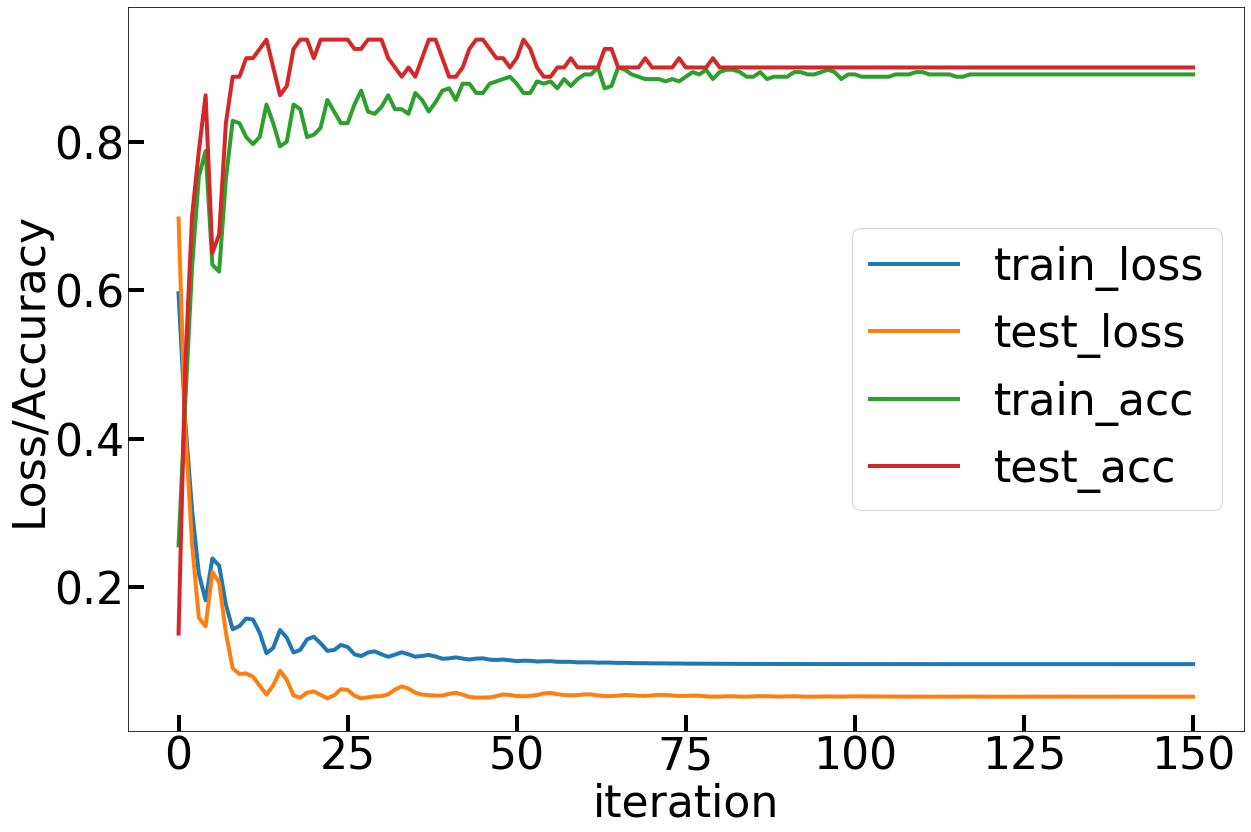

In [35]:
plt.figure(figsize=(20,13.33))
plt.plot(range(len(costs_train)), costs_train, linewidth=4, label='train_loss')
plt.plot(range(len(costs_test)), costs_test, linewidth=4, label='test_loss')
plt.plot(range(len(accuracy_train)), accuracy_train, linewidth=4, label='train_acc')
plt.plot(range(len(accuracy_test)), accuracy_test, linewidth=4, label='test_acc')
plt.tick_params(axis="x", which = 'major', direction="in", length=16, width=4)
plt.tick_params(axis="y", which = 'major', direction="in", length=16, width=4)
plt.tick_params(axis="y", which = 'minor', direction="in", length=8, width=4)
# plt.yscale('log')
plt.xlabel('iteration')
plt.legend(loc='center right')
plt.ylabel('Loss/Accuracy')
plt.savefig('time_qnn.png')
plt.savefig('time_qnn.eps', format='eps')

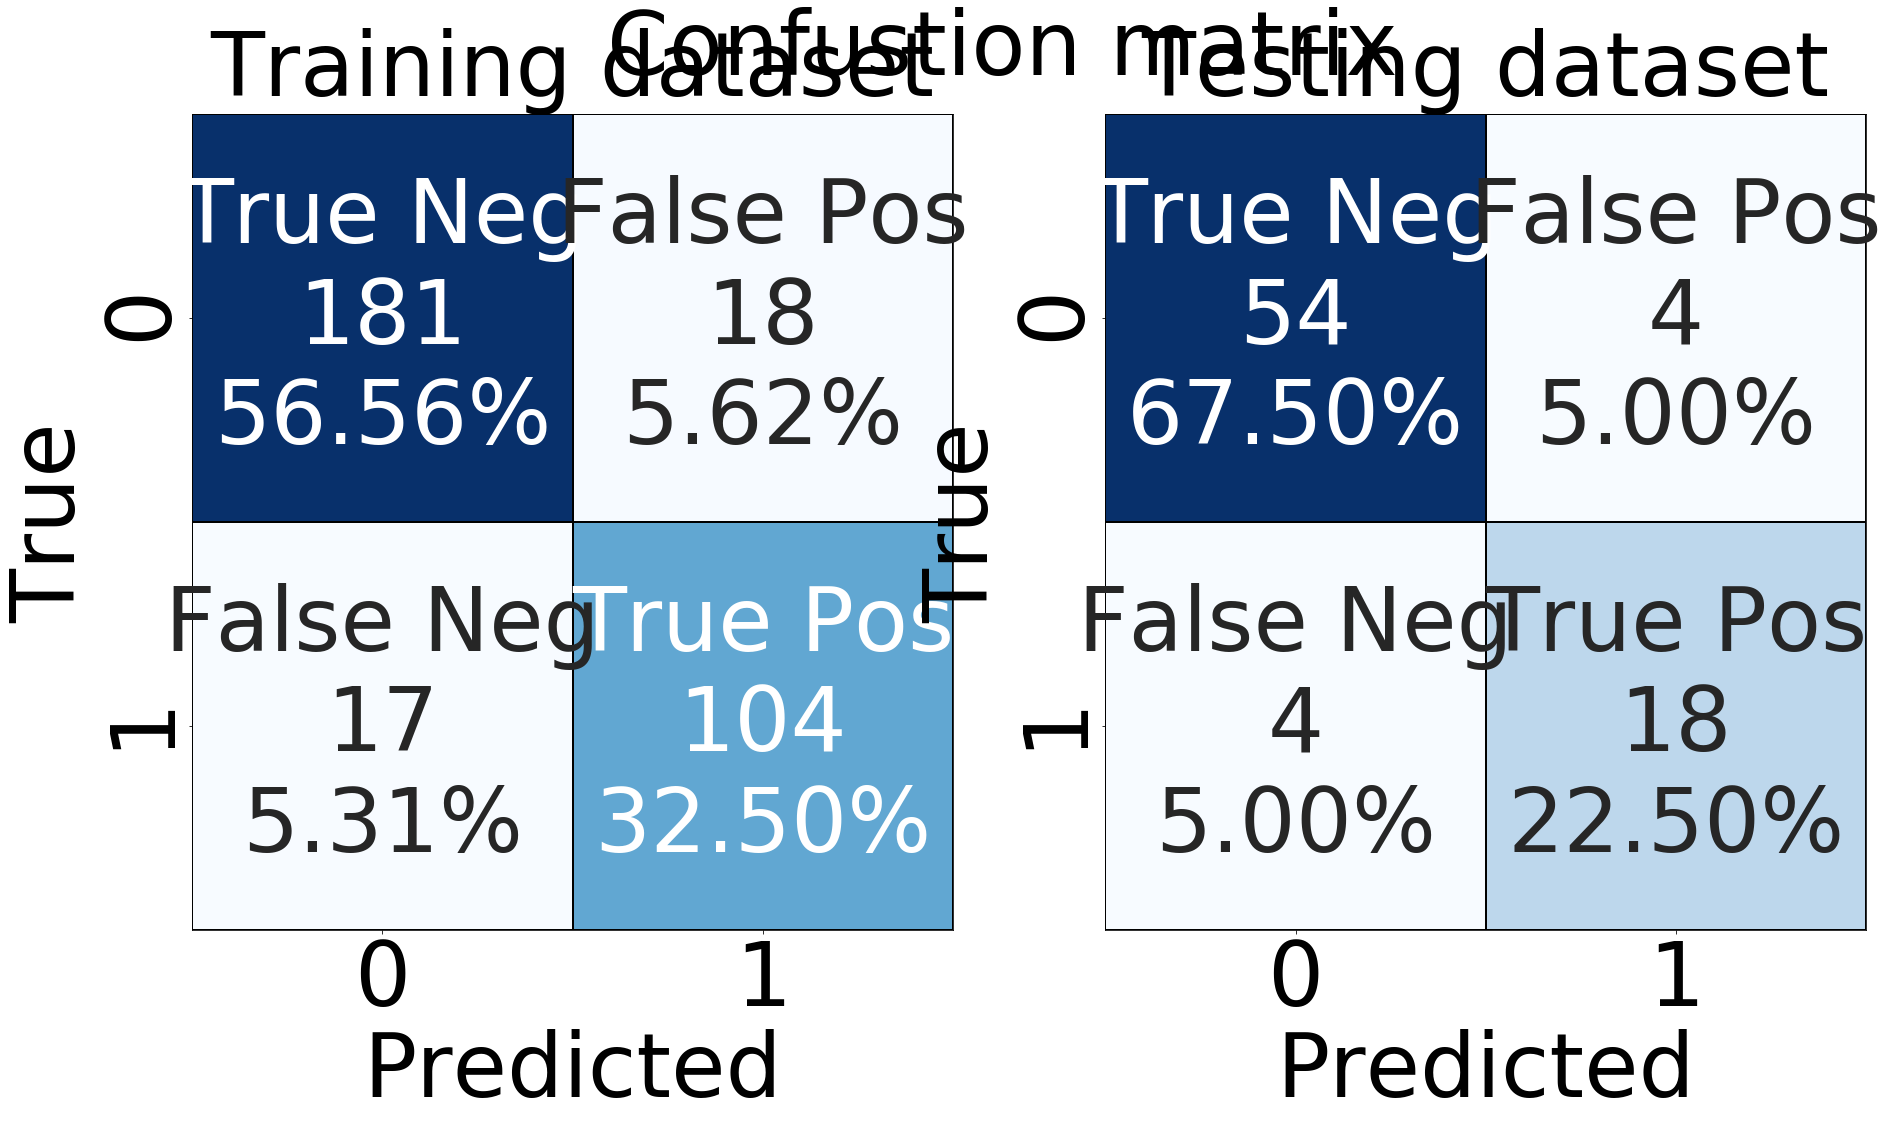

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Confustion matrix')

# Bulbasaur
cf_matrix = np.array([[181,  18], [17, 104]])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax1 = sns.heatmap(ax=axes[0], data=cf_matrix, annot=labels, fmt='', cmap="Blues", 
                 cbar=None, linewidths=1, linecolor="black")
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')
for _, spine in ax1.spines.items():
    spine.set_visible(True)
plt.xlabel('Predicted')
plt.ylabel('True')
axes[0].set_title('Training dataset')

# Charmander
cf_matrix = np.array([[54,  4], [4, 18]])

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax2 = sns.heatmap(ax=axes[1], data=cf_matrix, annot=labels, fmt='', cmap="Blues", 
                 cbar=None, linewidths=1, linecolor="black")
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')
for _, spine in ax2.spines.items():
    spine.set_visible(True)
axes[1].set_title('Testing dataset')

plt.savefig('confusion_matrix.png')
plt.savefig('confusion_matrix.eps', format='eps')

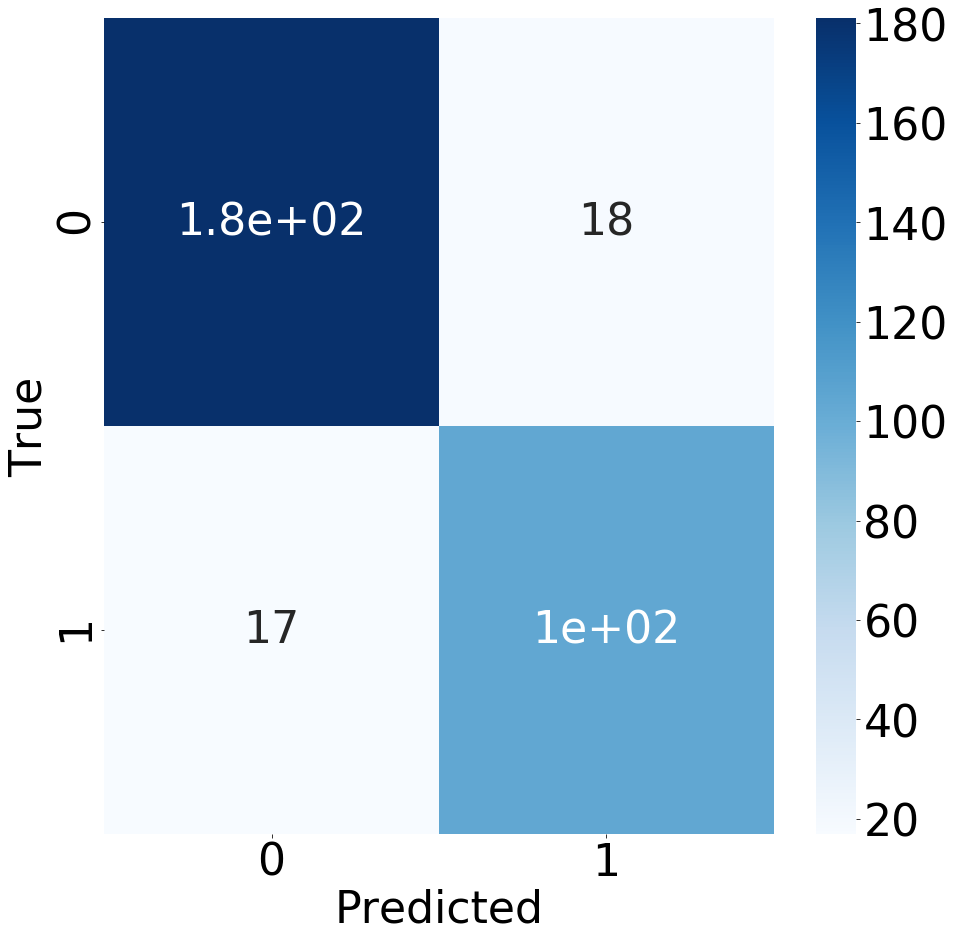

In [7]:
plt.figure(figsize=(15, 15))
label = y_train
pred = [predict(qnn_model(x, params)) for x in X_train]
pred = np.argmax(pred, axis=1)
con = confusion_matrix(label,pred)
sn_plot = sn.heatmap(con, annot=True, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('qnn_train.png')
plt.savefig('qnn_train.eps', format='eps')

In [16]:
label = y_train
pred = [predict(qnn_model(x, params)) for x in X_train]
pred = np.argmax(pred, axis=1)
confusion_matrix(label,pred)

array([[181,  18],
       [ 17, 104]], dtype=int64)

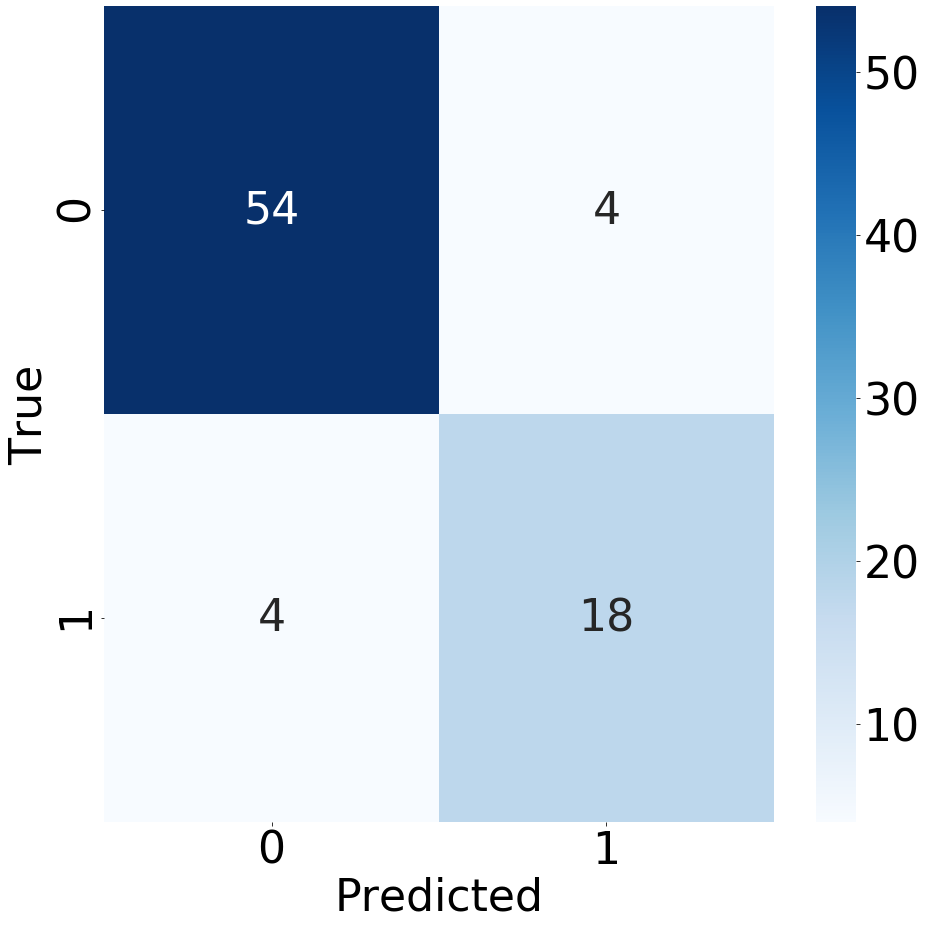

In [8]:
plt.figure(figsize=(15,15))
label = y_test
pred = [predict(qnn_model(x, params)) for x in X_test]
pred = np.argmax(pred, axis=1)
con = confusion_matrix(label,pred)
sn_plot = sn.heatmap(con, annot=True, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('qnn_test.png')
plt.savefig('qnn_test.eps', format='eps')

In [15]:
label = y_test
pred = [predict(qnn_model(x, params)) for x in X_test]
pred = np.argmax(pred, axis=1)
confusion_matrix(label,pred)

array([[54,  4],
       [ 4, 18]], dtype=int64)